1. Kompresja obrazów z użyciem sieci neuronowej  

·         Zbiór danych Fashion-MNIST X 

·         Budujemy sieć neuronową dla kompresji danych, a następnie próbujemy sprawdzić czy sieć jest wstanie rozpoznać (poprawnie skwalifikować) dane z dekodera. Proszę również pokazać że sieć do kompresji można „rozciąć” na układ koder-dekoder. X

Tworzymy auto-enkoder i w pierwszej kolejności chcemy pokazać zależność błędu pomiędzy wyjściem a wejściem w stosunku do stopnia kompresji, 

Następnie patrzymy dla jakiś sensownych – wybranych - punktów z powyższej krzywej jak wygląda klasyfikacja danych zakodowanych.        Dla każdego wyniku stosujemy różne miary błędu (ewaluacji) MSE, macierz pomyłek, krzywe ROC, specyficzność czułość, pole pod ROC itp.  

·         Wyniki proszę porównać z istniejącymi w literaturze.  

# Implemntacja 1 enkodera

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.layers import *
from keras.models import Model, load_model
from keras.datasets import mnist
from keras.callbacks import ReduceLROnPlateau
from keras import regularizers
from keras import optimizers
from keras import backend as K
import scipy
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()


x_train = np.array(x_train).reshape(-1, 28, 28) / 255.0
x_test = np.array(x_test).reshape(-1, 28, 28) / 255.0

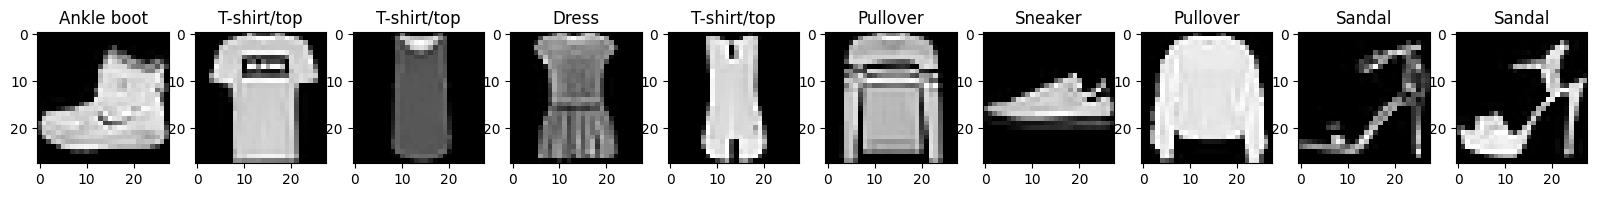

In [5]:
labeldict = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

fig, ax = plt.subplots(1, 10, figsize=(20, 2))
for i in range(10):
    ax[i].imshow(x_train[i], cmap='gray')
    ax[i].set_title(labeldict[y_train[i]])

In [6]:
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

# Klasa która pozwala tworzyć autoenkoder o wybranym poziomie kompresji 
# compression_level:
# - 1 -> compresion with 1 MaxPooling2D layer 
# - 2 -> compresion with 2 MaxPooling2D layer
# - 3 -> compresion with 2 MaxPooling2D layer and danse layer 

class MaxPooling_autoencoder:
    def __init__(self, x_train, x_test, y_train, y_test, compression_level):
        self.x_train = x_train
        self.x_test = x_test
        self.y_train = y_train
        self.y_test = y_test
        self.compression_level = compression_level
        self.input = Input(shape=(28, 28, 1))
        self.model, self.encoder, self.decoder = self.build_model(compression_level)

    def build_model(self, comp_level):
        #building encoder
        inputs = self.input

        if(comp_level == 1): 
            x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
            x = BatchNormalization()(x)
            x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
            x = BatchNormalization()(x)
            x = MaxPooling2D(pool_size=(2, 2))(x)
            x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
            x = BatchNormalization()(x)
            x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
            encoded = BatchNormalization()(x)
            encoder = Model(inputs=inputs, outputs=encoded)

            x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
            x = BatchNormalization()(x)
            x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
            x = BatchNormalization()(x)
            x = UpSampling2D((2, 2))(x)
            x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
            x = BatchNormalization()(x)
            x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
            x = BatchNormalization()(x)
            x = UpSampling2D((2, 2))(x)
            decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
            decoder = Model(inputs=encoded, outputs=decoded)

        elif(comp_level == 2):
            x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
            x = BatchNormalization()(x)
            x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
            x = BatchNormalization()(x)
            x = MaxPooling2D(pool_size=(2, 2))(x)
            x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
            x = BatchNormalization()(x)
            x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
            x = BatchNormalization()(x)
            x = MaxPooling2D(pool_size=(2, 2))(x)
            x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
            x = BatchNormalization()(x)
            x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
            encoded = BatchNormalization()(x)
            encoder = Model(inputs=inputs, outputs=encoded)

            x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
            x = BatchNormalization()(x)
            x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
            x = BatchNormalization()(x)
            x = UpSampling2D((2, 2))(x)
            x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
            x = BatchNormalization()(x)
            x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
            x = BatchNormalization()(x)
            x = UpSampling2D((2, 2))(x)
            x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
            x = BatchNormalization()(x)
            x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
            decoded = BatchNormalization()(x)
            decoder = Model(inputs=encoded, outputs=decoded)

        else:
            x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
            x = BatchNormalization()(x)
            x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
            x = BatchNormalization()(x)
            x = MaxPooling2D(pool_size=(2, 2))(x)
            x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
            x = BatchNormalization()(x)
            x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
            x = BatchNormalization()(x)
            x = MaxPooling2D(pool_size=(2, 2))(x)
            x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
            x = BatchNormalization()(x)
            x = Conv2D(4, (2, 2), activation='relu', padding='same')(x)
            x = Conv2D(1, (2, 2), activation='relu', padding='same')(x)
            x = Flatten()(x)
            encoded = Dense(2, activation='relu')(x)
            encoder = Model(inputs=inputs, outputs=encoded)

            x = Dense(2, activation='relu')(encoded)
            x = Reshape((1, 1, 2))(x)
            x = Conv2DTranspose(4, (2, 2), activation='relu', padding='same')(x)
            x = Conv2DTranspose(8, (3, 3), activation='relu', padding='same')(x)
            x = BatchNormalization()(x)
            x = Conv2DTranspose(16, (3, 3), activation='relu', padding='same')(x)
            x = BatchNormalization()(x)
            x = UpSampling2D((2, 2))(x)
            x = Conv2DTranspose(16, (3, 3), activation='relu', padding='same')(x)
            x = BatchNormalization()(x)
            x = Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
            x = BatchNormalization()(x)
            x = UpSampling2D((2, 2))(x)
            x = Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
            x = BatchNormalization()(x)
            decoded = Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')(x)
            decoder = Model(inputs=encoded, outputs=decoded)
        
        x = encoder(inputs)
        x = decoder(x)
        model = Model(inputs=inputs, outputs=x)
        model.compile(optimizer=optimizers.Adam(1e-3), 
                      loss='binary_crossentropy', 
                      metrics=['accuracy', 'mse']) ## metryki do ustalenia
        return model, encoder, decoder




1/1 [==============================] - 0s 17ms/step


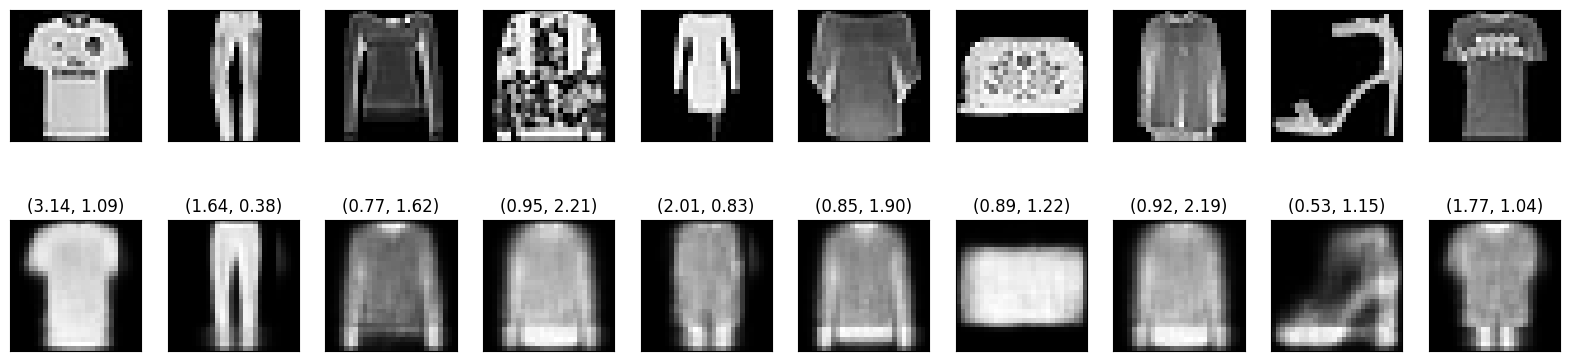

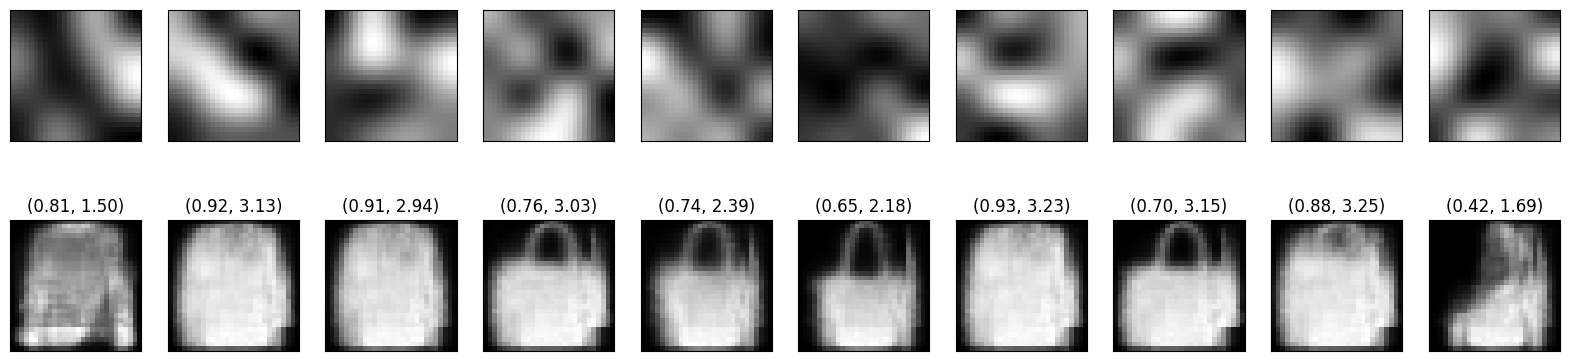

In [ ]:
def get_triple(inputs):
    latent_repr = encoder.predict(inputs)
    outputs = decoder.predict(latent_repr)
    latent_repr = latent_repr.reshape((latent_repr.shape[0], latent_repr.shape[1], 1))

    return inputs, latent_repr, outputs

def show_encodings(inputs, latent_repr, outputs):
    n = len(inputs)
    fig, axes = plt.subplots(2, n, figsize=(2*n, 5))
    for i in range(n):
        axes[1, i].set_title('({0:.2f}, {1:.2f})'.format(float(latent_repr[i, 0]), float(latent_repr[i, 1])))
        axes[0, i].imshow(inputs[i].reshape(28, 28), cmap='gray')
        axes[1, i].imshow(outputs[i].reshape(28, 28), cmap='gray')
    for ax in axes.flatten():
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

show_encodings(*get_triple(x_test[:10]))
inputs = np.random.random(size=(10, 4, 4, 1))
inputs = scipy.ndimage.zoom(inputs, (1, 7, 7, 1))
show_encodings(*get_triple(inputs))

313/313 [==============================] - 1s 2ms/step


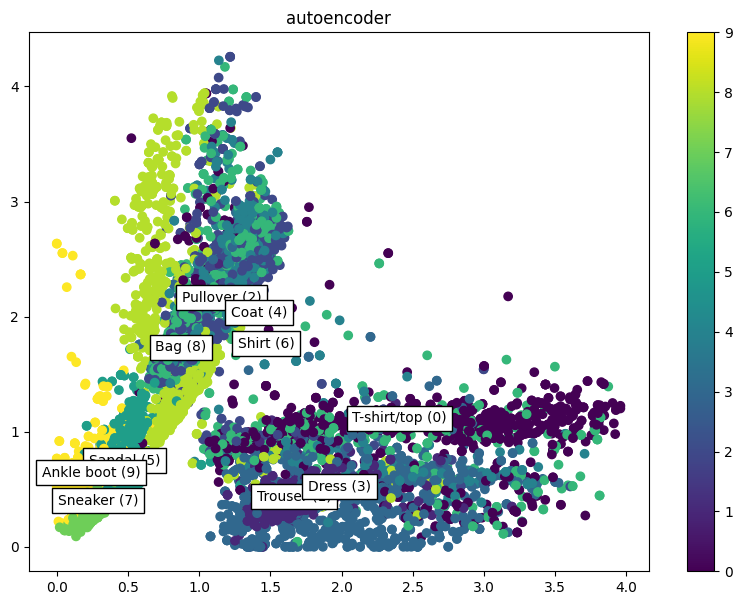

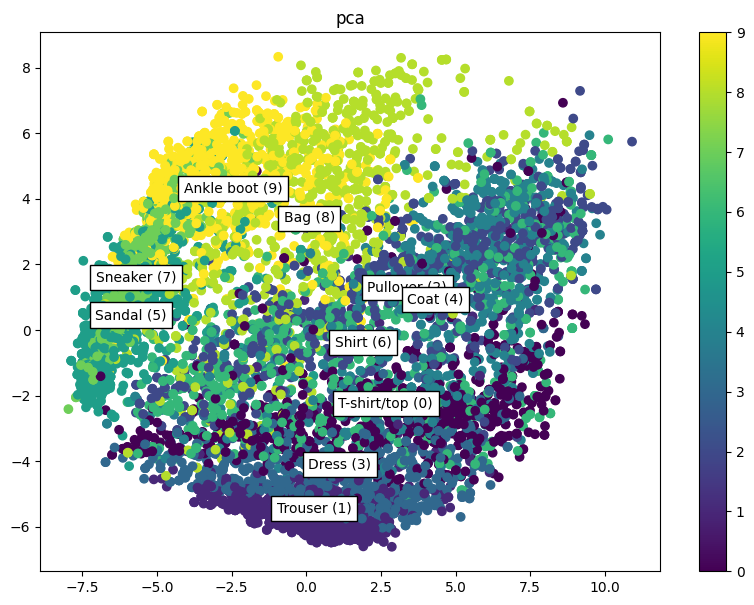

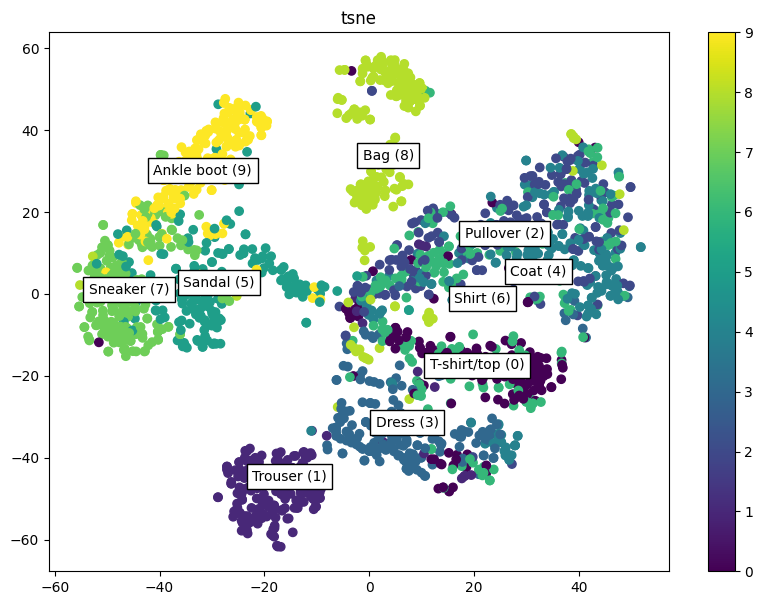

10/10 [==============================] - 0s 22ms/step


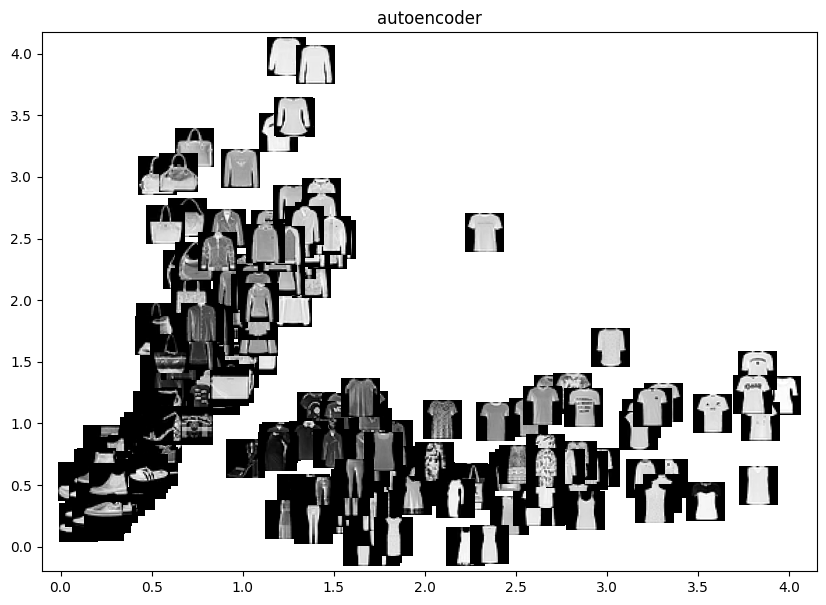

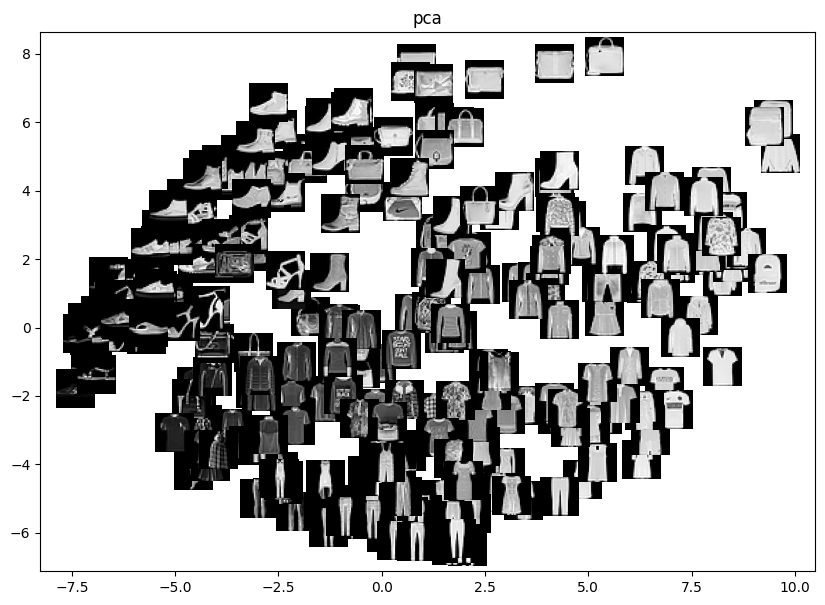

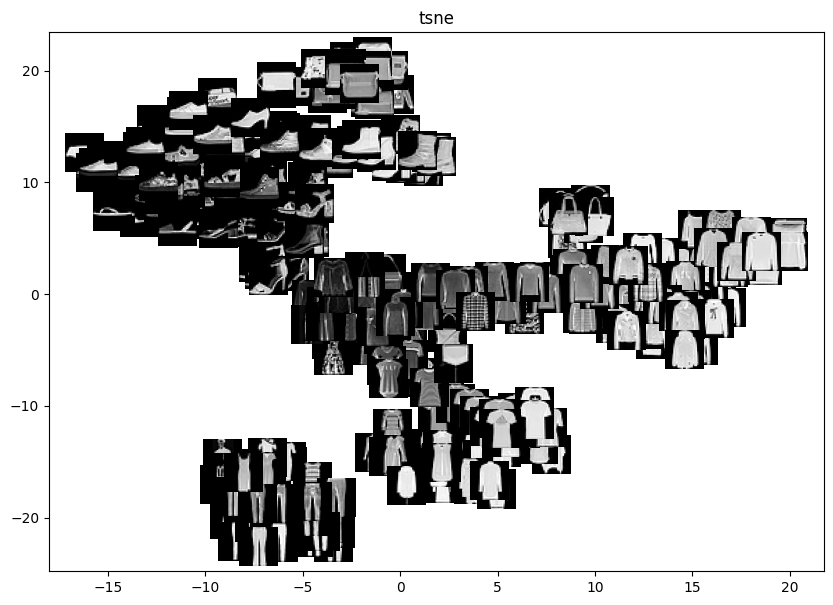

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

def plot_latent(mode, count, technique):
    idx = np.random.choice(len(x_test), count)
    inputs = x_test[idx]
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.set_title(technique)
    if technique == 'autoencoder':
        coords = encoder.predict(inputs)
    elif technique == 'pca':
        coords = PCA(n_components=2).fit_transform(inputs.reshape(count, -1))
    elif technique == 'tsne':
        coords = TSNE(n_components=2).fit_transform(inputs.reshape(count, -1))

    if mode == 'imgs':
        for image, (x, y) in zip(inputs, coords):
            im = OffsetImage(image.reshape(28, 28), zoom=1, cmap='gray')
            ab = AnnotationBbox(im, (x, y), xycoords='data', frameon=False)
            ax.add_artist(ab)
        ax.update_datalim(coords)
        ax.autoscale()
    elif mode == 'dots':
        classes = y_test[idx]
        plt.scatter(coords[:, 0], coords[:, 1], c=classes)
        plt.colorbar()
        for i in range(10):
            class_center = np.mean(coords[classes == i], axis=0)
            text = TextArea('{} ({})'.format(labeldict[i], i))
            ab = AnnotationBbox(text, class_center, xycoords='data', frameon=True)
            ax.add_artist(ab)
    plt.show()

plot_latent('dots', 10000, 'autoencoder')
plot_latent('dots', 10000, 'pca')
plot_latent('dots', 2000, 'tsne')

plot_latent('imgs', 300, 'autoencoder')
plot_latent('imgs', 300, 'pca')
plot_latent('imgs', 300, 'tsne')